In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
X_normalized = pd.read_csv("crime_normalized_features.csv")
Y_normalized = pd.read_csv("crime_normalized_targets.csv")

# Replace "?" with NaN in both X and Y
X_normalized = X_normalized.replace("?", np.nan)
Y_normalized = Y_normalized.replace("?", np.nan)

# Prepare numeric dataframe with target included
numeric_df = X_normalized.apply(pd.to_numeric, errors='coerce')
numeric_df['ViolentCrimesPerPop'] = pd.to_numeric(Y_normalized['ViolentCrimesPerPop'], errors='coerce')
numeric_df = numeric_df.dropna(axis=1, how='all')


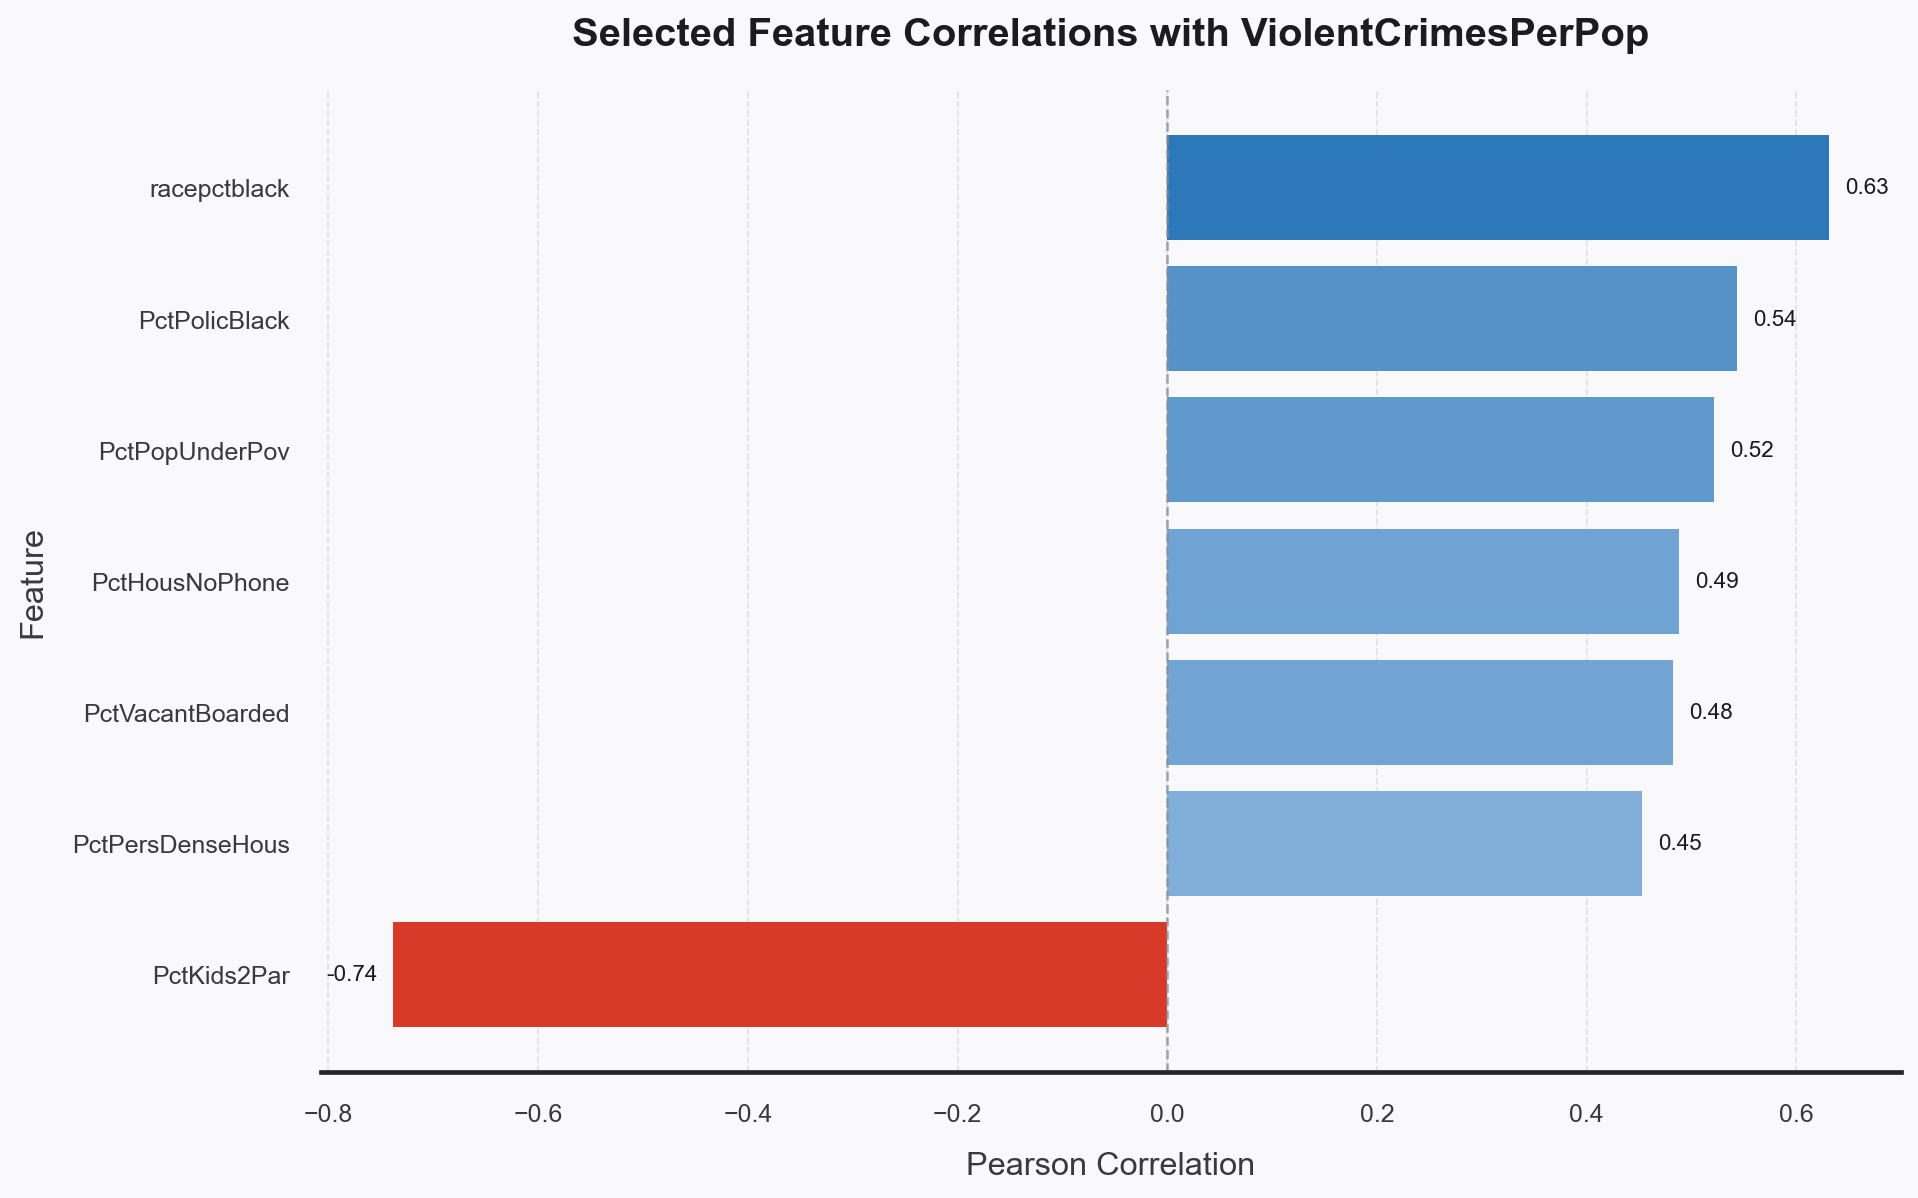

In [34]:
from matplotlib.colors import LinearSegmentedColormap
selected_features = [
    'racepctblack',
    'PctPolicBlack',
    'PctPopUnderPov',
    'PctKids2Par',
    'PctVacantBoarded',
    'PctPersDenseHous',
    'PctHousNoPhone',
]

missing_features = sorted(set(selected_features) - set(numeric_df.columns))
if missing_features:
    raise KeyError(f"Missing features: {missing_features}. Ensure previous cells ran successfully.")

selected_df = numeric_df[selected_features]
raw_corr = selected_df.corrwith(numeric_df['ViolentCrimesPerPop'])
positive_corr = raw_corr[raw_corr >= 0].sort_values(ascending=False)
negative_corr = raw_corr[raw_corr < 0].sort_values(ascending=False)
selected_target_corr = pd.concat([positive_corr, negative_corr])

corr_summary = selected_target_corr.to_frame('Correlation')

sns.set_theme(style='white', context='talk')
fig, ax = plt.subplots(figsize=(11, max(7, len(selected_target_corr) * 0.32)), dpi=180)
cmap = LinearSegmentedColormap.from_list('corr-gradient', ['#d7301f', '#fdd49e', '#f7f7f7', '#d0e1f9', '#2171b5'])
vals = selected_target_corr.values
norm = (vals - vals.min()) / (vals.max() - vals.min())
colors = [cmap(v) for v in norm]
ax.barh(selected_target_corr.index, vals, color=colors, edgecolor='none', alpha=0.95)
ax.invert_yaxis()

ax.set_title('Selected Feature Correlations with ViolentCrimesPerPop', fontsize=16, fontweight='bold', pad=18, color='#1c1c1e')
ax.set_xlabel('Pearson Correlation', fontsize=13, labelpad=10, color='#3a3a3c')
ax.set_ylabel('Feature', fontsize=13, labelpad=10, color='#3a3a3c')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', color='#d2d2d7', linestyle='--', linewidth=0.7, alpha=0.6)
ax.axvline(0, color='#8e8e93', linewidth=1, linestyle='--', alpha=0.8)
ax.tick_params(axis='both', colors='#3a3a3c', labelsize=10)

for y_pos, value in enumerate(selected_target_corr.values):
    offset = 0.015 if value >= 0 else -0.015
    ha = 'left' if value >= 0 else 'right'
    ax.text(value + offset, y_pos, f"{value:.2f}", va='center', ha=ha, fontsize=9, color='#1c1c1e', fontweight='medium')

fig.patch.set_facecolor('#f9f9fb')
ax.set_facecolor('#f9f9fb')
plt.tight_layout()


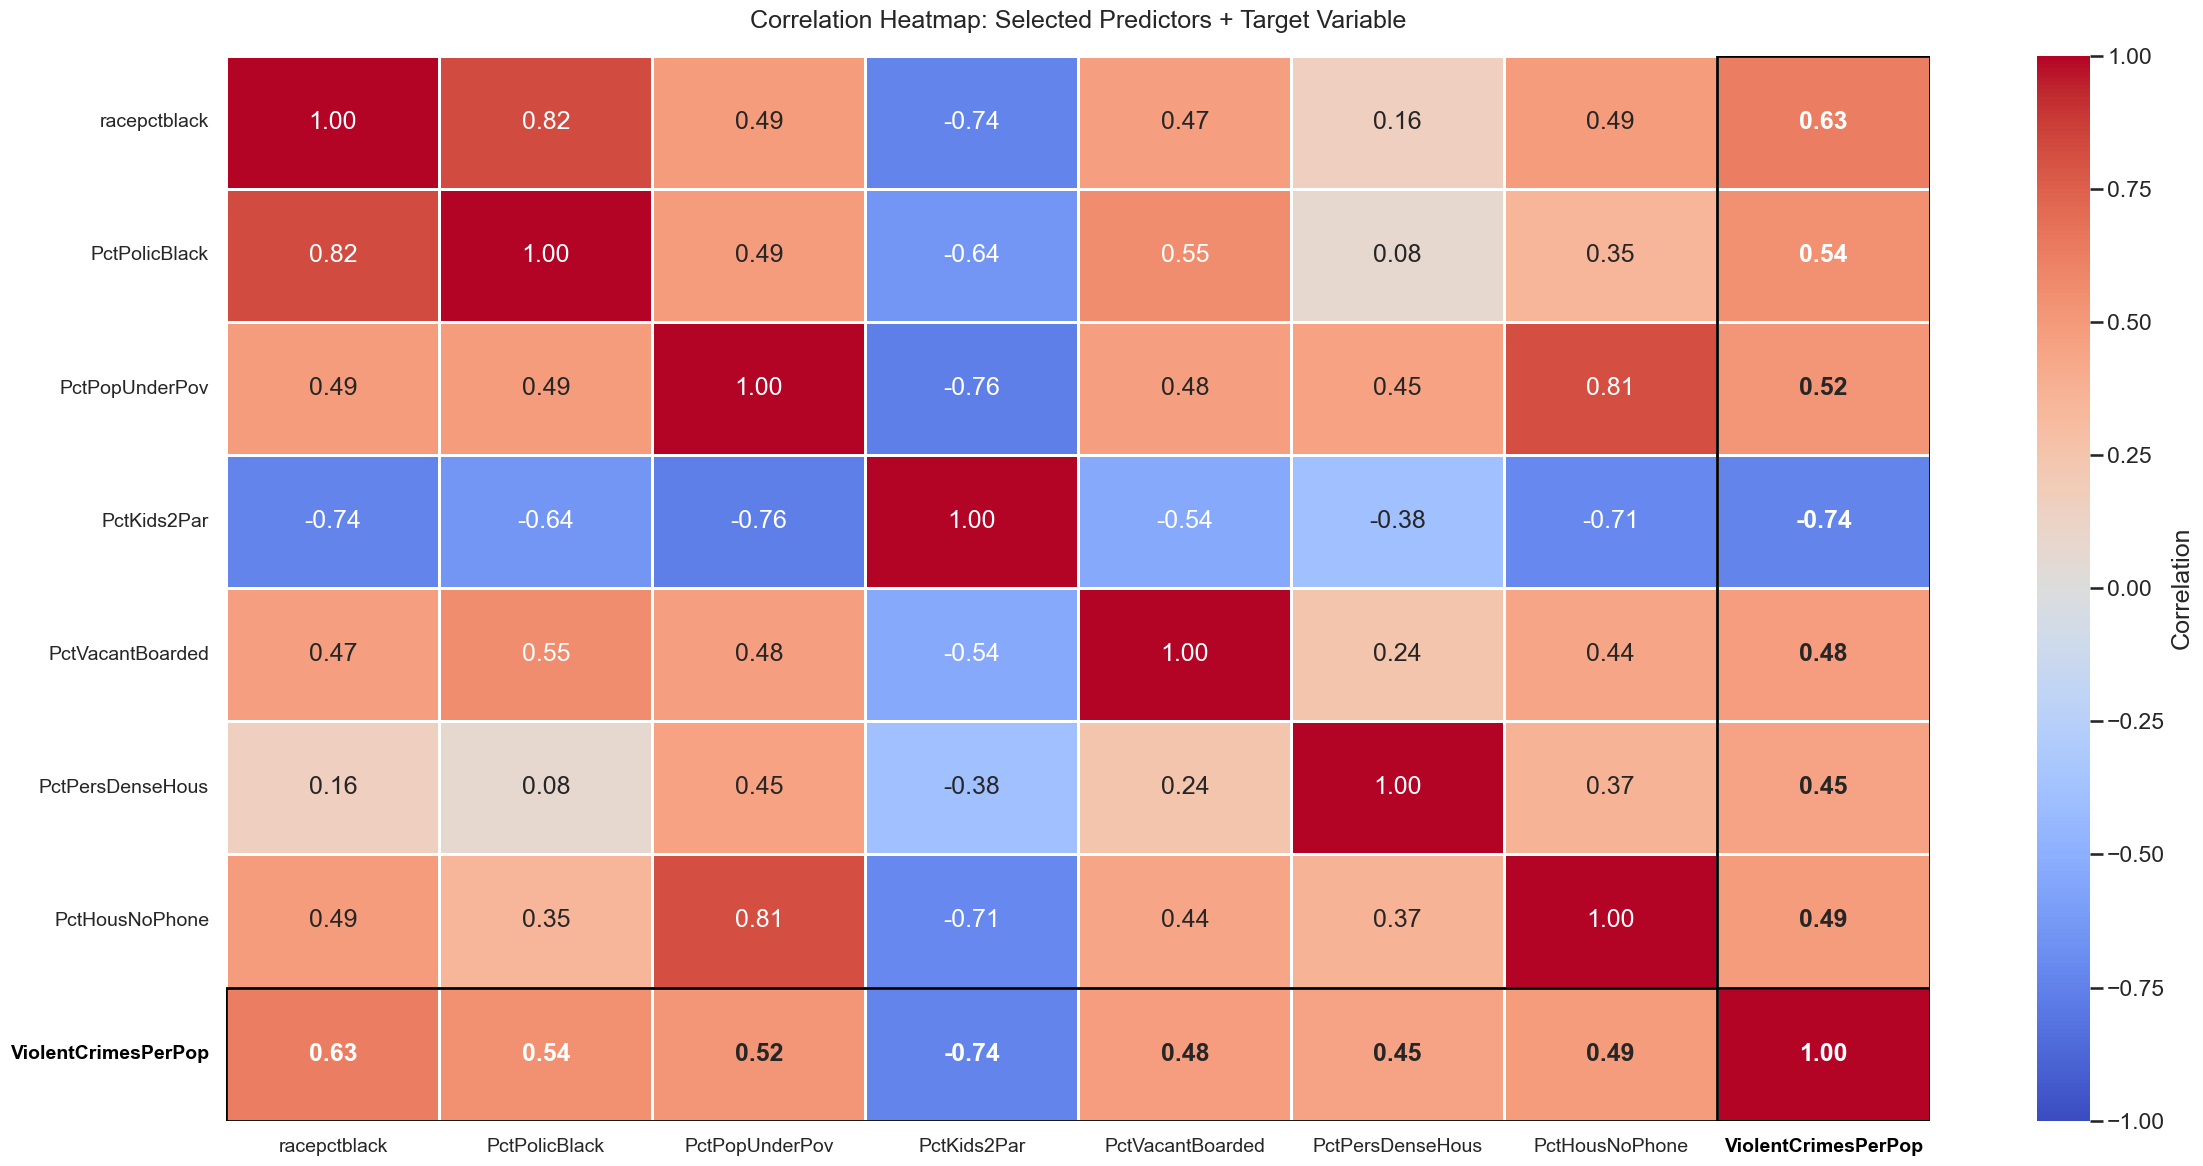

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create dataframe with selected features plus target variable
features_with_target = selected_features + ['ViolentCrimesPerPop']
heatmap_df = numeric_df[features_with_target]

# Create correlation matrix
corr_matrix = heatmap_df.corr()

# Plot
fig, ax = plt.subplots(figsize=(24, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=False,
    linewidths=1,
    cbar_kws={'label': 'Correlation'},
    vmin=-1,
    vmax=1,
    ax=ax,
)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)

# ---- Make ViolentCrimesPerPop bold on both axes ----
target = 'ViolentCrimesPerPop'

for lbl in ax.get_xticklabels():
    if lbl.get_text() == target:
        lbl.set_fontweight('bold')
        lbl.set_color('black')   # optional: ensure readable

for lbl in ax.get_yticklabels():
    if lbl.get_text() == target:
        lbl.set_fontweight('bold')
        lbl.set_color('black')

# ---- (Optional) Also bold the annotation text for the entire row/column ----
labels = corr_matrix.columns.tolist()
idx = labels.index(target)
n = len(labels)

# Each cell's annotation is a Text at (col+0.5, row+0.5).
for t in ax.texts:
    x, y = t.get_position()
    j = int(round(x - 0.5))  # column index
    i = int(round(y - 0.5))  # row index
    if i == idx or j == idx:
        t.set_fontweight('bold')

# ---- (Optional) Visually outline the row/column for extra emphasis ----
# Column outline
ax.add_patch(plt.Rectangle((idx, 0), 1, n, fill=False, edgecolor='black', linewidth=2))
# Row outline
ax.add_patch(plt.Rectangle((0, idx), n, 1, fill=False, edgecolor='black', linewidth=2))

ax.set_title('Correlation Heatmap: Selected Predictors + Target Variable', fontsize=18, pad=20)
plt.tight_layout()
plt.show()


In [36]:
# Data cleaning: Remove rows with missing values in selected features
print(f"Original dataset shape: {numeric_df.shape}")
print(f"Missing values in selected features:\n{numeric_df[selected_features].isnull().sum()}\n")

# Drop rows with any NaN in the selected features
numeric_df_clean = numeric_df.dropna(subset=selected_features)

print(f"After removing rows with NaN: {numeric_df_clean.shape}")
print(f"Rows removed: {numeric_df.shape[0] - numeric_df_clean.shape[0]}")
print(f"Percentage of data retained: {(numeric_df_clean.shape[0] / numeric_df.shape[0] * 100):.1f}%")

Original dataset shape: (1994, 127)
Missing values in selected features:
racepctblack           0
PctPolicBlack       1675
PctPopUnderPov         0
PctKids2Par            0
PctVacantBoarded       0
PctPersDenseHous       0
PctHousNoPhone         0
dtype: int64

After removing rows with NaN: (319, 127)
Rows removed: 1675
Percentage of data retained: 16.0%


In [37]:
from sklearn.preprocessing import StandardScaler

# Prepare data for PCA (using cleaned data)
X = numeric_df_clean[selected_features].values
y = numeric_df_clean['ViolentCrimesPerPop'].values
n_samples, n_features = X.shape

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA using SVD (as in HW08)
U, s, Vt = np.linalg.svd(X_scaled, full_matrices=False)
V = Vt.T

# Calculate variance metrics
eigenvalues = s**2 / (n_samples - 1)
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features}")
print(f"Eigenvalues:\n{eigenvalues}")
print(f"Explained variance ratio:\n{explained_variance_ratio}")

Number of samples: 319
Number of features: 7
Eigenvalues:
[4.22218866 1.14713381 0.71231484 0.43590863 0.20916089 0.19083082
 0.10447493]
Explained variance ratio:
[0.60127899 0.16336254 0.10144027 0.06207745 0.02978646 0.02717609
 0.0148782 ]


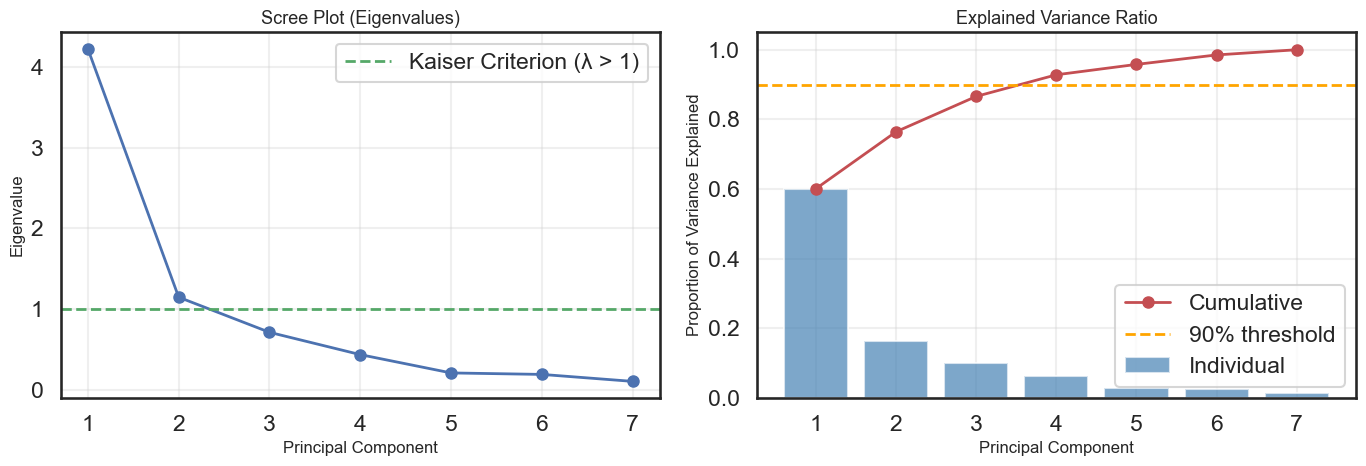

Components to keep by Kaiser criterion (λ > 1): 2


In [38]:
# Scree Plot with Kaiser Criterion
kaiser_threshold = 1  # Eigenvalue > 1 rule (for correlation matrix PCA)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scree Plot (Eigenvalues)
ax1.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=kaiser_threshold, color='g', linestyle='--', linewidth=2, label='Kaiser Criterion (λ > 1)')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Eigenvalue', fontsize=12)
ax1.set_title('Scree Plot (Eigenvalues)', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(eigenvalues) + 1))

# Plot 2: Explained Variance
ax2.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
        alpha=0.7, label='Individual', color='steelblue')
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         'ro-', linewidth=2, markersize=8, label='Cumulative')
ax2.axhline(y=0.90, color='orange', linestyle='--', linewidth=2, label='90% threshold')
ax2.set_xlabel('Principal Component', fontsize=12)
ax2.set_ylabel('Proportion of Variance Explained', fontsize=12)
ax2.set_title('Explained Variance Ratio', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, len(explained_variance_ratio) + 1))

plt.tight_layout()
plt.show()

# Kaiser selection
n_kaiser = np.sum(eigenvalues > 1)
print(f"Components to keep by Kaiser criterion (λ > 1): {n_kaiser}")

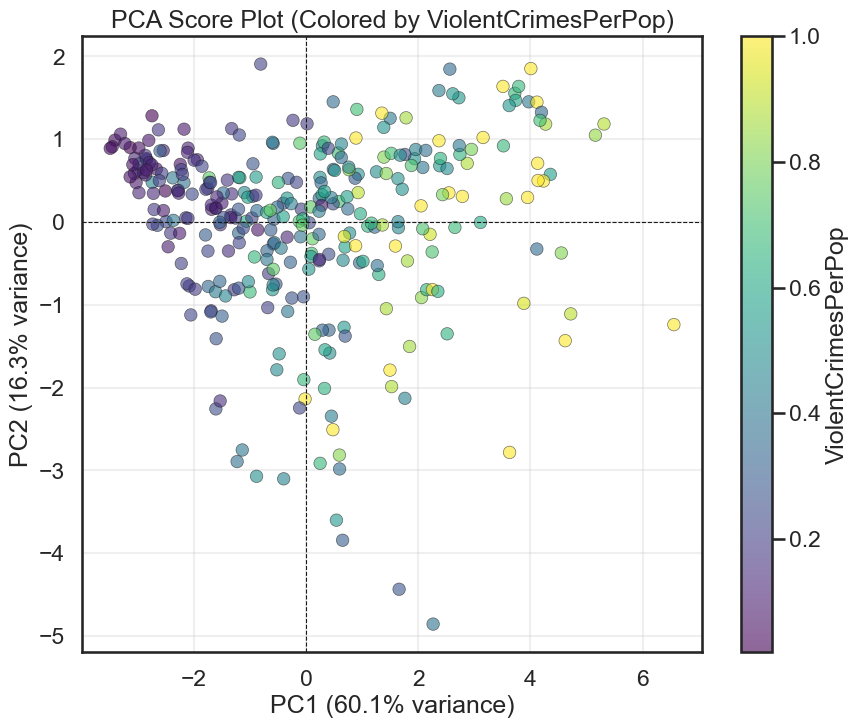

In [39]:
# Score Plot (PC1 vs PC2)
scores = X_scaled @ V
pc1 = scores[:, 0]
pc2 = scores[:, 1]

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(pc1, pc2, c=y, cmap='viridis', alpha=0.6, edgecolor='k', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax, label='ViolentCrimesPerPop')

ax.set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
ax.set_title('PCA Score Plot (Colored by ViolentCrimesPerPop)')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='k', linestyle='--', linewidth=0.8)
ax.axvline(0, color='k', linestyle='--', linewidth=0.8)

plt.show()

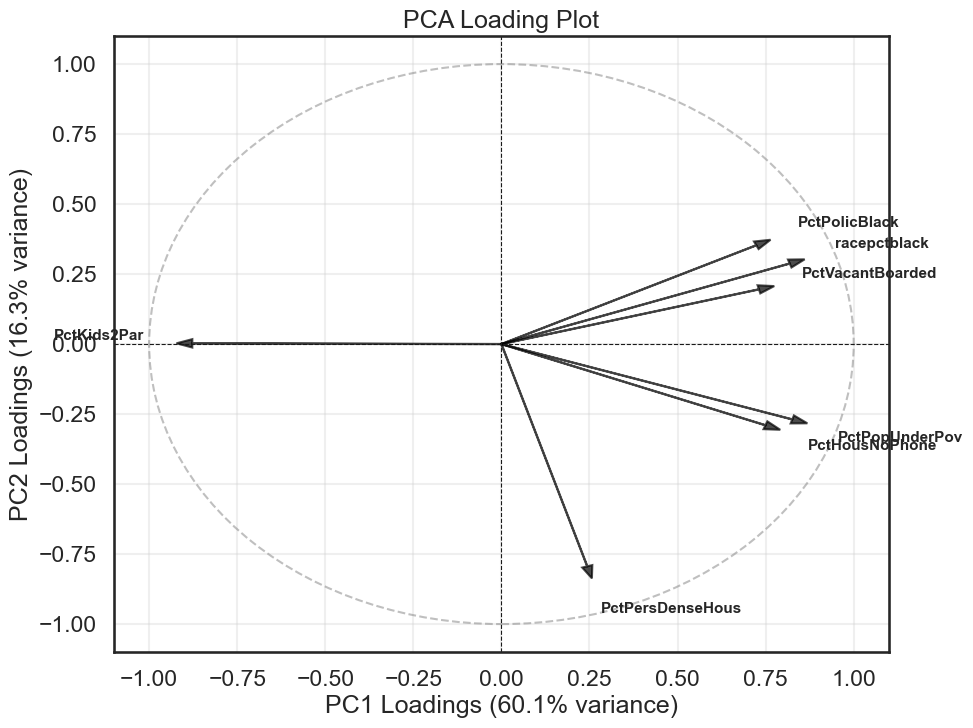

In [40]:
# Loading Plot
# Calculate loadings (correlation between original variables and PCs)
loadings = V * (s / np.sqrt(n_samples - 1))
loadings_pc1 = loadings[:, 0]
loadings_pc2 = loadings[:, 1]

fig, ax = plt.subplots(figsize=(10, 8))

for i, feature in enumerate(selected_features):
    # Use distinct variable names to avoid overwriting global 'x' and 'y'
    feat_x = loadings_pc1[i]
    feat_y = loadings_pc2[i]
    
    # Draw arrow
    ax.arrow(0, 0, feat_x, feat_y, color='black', alpha=0.7, head_width=0.03, length_includes_head=True)
    
    # Add text label
    # Adjust alignment based on quadrant
    ha = 'left' if feat_x >= 0 else 'right'
    va = 'bottom' if feat_y >= 0 else 'top'
    ax.text(feat_x * 1.1, feat_y * 1.1, feature, ha=ha, va=va, fontsize=11, fontweight='bold')

# Draw unit circle (for correlation loadings, max is 1)
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
ax.add_artist(circle)

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel(f'PC1 Loadings ({explained_variance_ratio[0]:.1%} variance)')
ax.set_ylabel(f'PC2 Loadings ({explained_variance_ratio[1]:.1%} variance)')
ax.set_title('PCA Loading Plot')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='k', linestyle='--', linewidth=0.8)
ax.axvline(0, color='k', linestyle='--', linewidth=0.8)

plt.show()

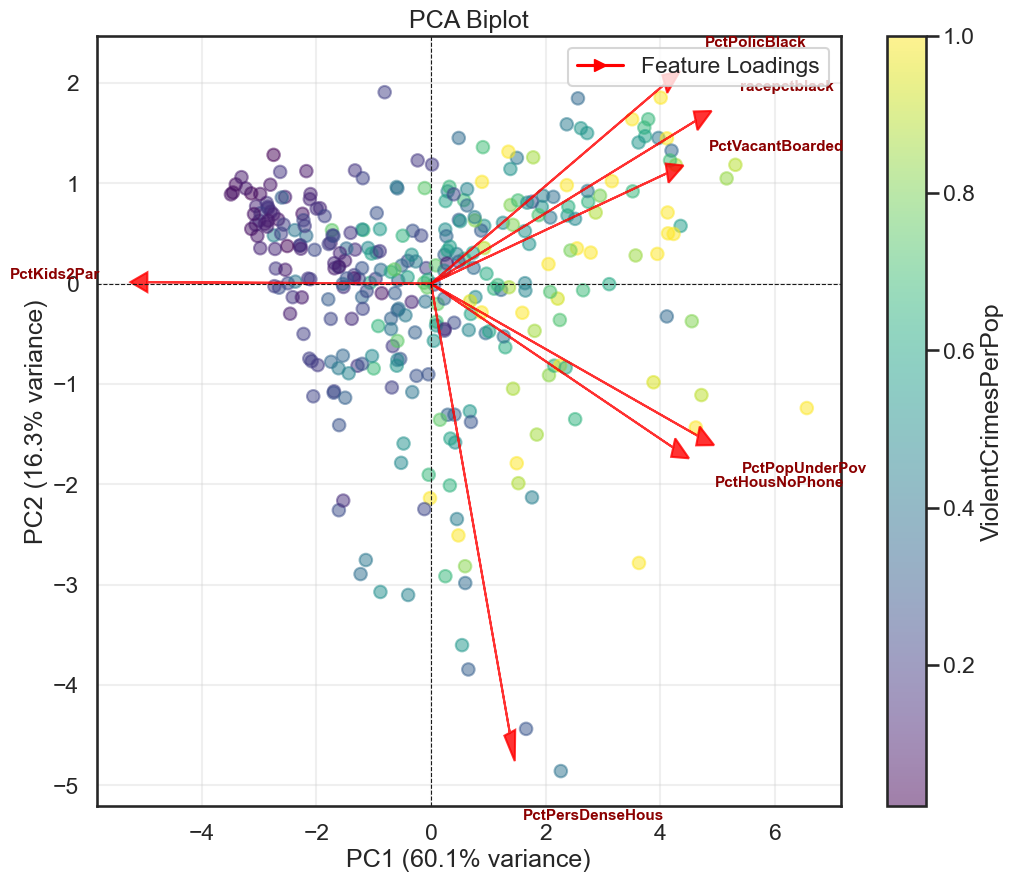

In [41]:
# Biplot (Scores + Loadings)
scores_2d = scores[:, :2]
loadings_2d = loadings[:, :2]

# Calculate scaling factor to fit loadings on the same plot as scores
score_max = np.max(np.abs(scores_2d))
loading_max = np.max(np.abs(loadings_2d))
scaling_factor = score_max / loading_max * 0.8  # Scale loadings to 80% of score range

loadings_scaled = loadings_2d * scaling_factor

fig, ax = plt.subplots(figsize=(12, 10))

# Plot Scores
# Ensure 'y' is the target variable array, not a loop variable
scatter = ax.scatter(pc1, pc2, c=numeric_df_clean['ViolentCrimesPerPop'], cmap='viridis', alpha=0.5, label='Observations')
plt.colorbar(scatter, ax=ax, label='ViolentCrimesPerPop')

# Plot Loadings
for i, feature in enumerate(selected_features):
    feat_x = loadings_scaled[i, 0]
    feat_y = loadings_scaled[i, 1]
    
    ax.arrow(0, 0, feat_x, feat_y, color='red', alpha=0.8, head_width=score_max*0.03, length_includes_head=True, linewidth=1.5)
    
    # Add text label
    ha = 'left' if feat_x >= 0 else 'right'
    va = 'bottom' if feat_y >= 0 else 'top'
    ax.text(feat_x * 1.1, feat_y * 1.1, feature, ha=ha, va=va, color='darkred', fontsize=11, fontweight='bold')

ax.set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
ax.set_title('PCA Biplot')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='k', linestyle='--', linewidth=0.8)
ax.axvline(0, color='k', linestyle='--', linewidth=0.8)

# Add legend for arrows
import matplotlib.lines as mlines
arrow_proxy = mlines.Line2D([], [], color='red', marker='>', linestyle='-', label='Feature Loadings')
ax.legend(handles=[arrow_proxy], loc='upper right')

plt.show()

Analyzing 126 features...
Number of PCs needed to explain 90% variance: 33


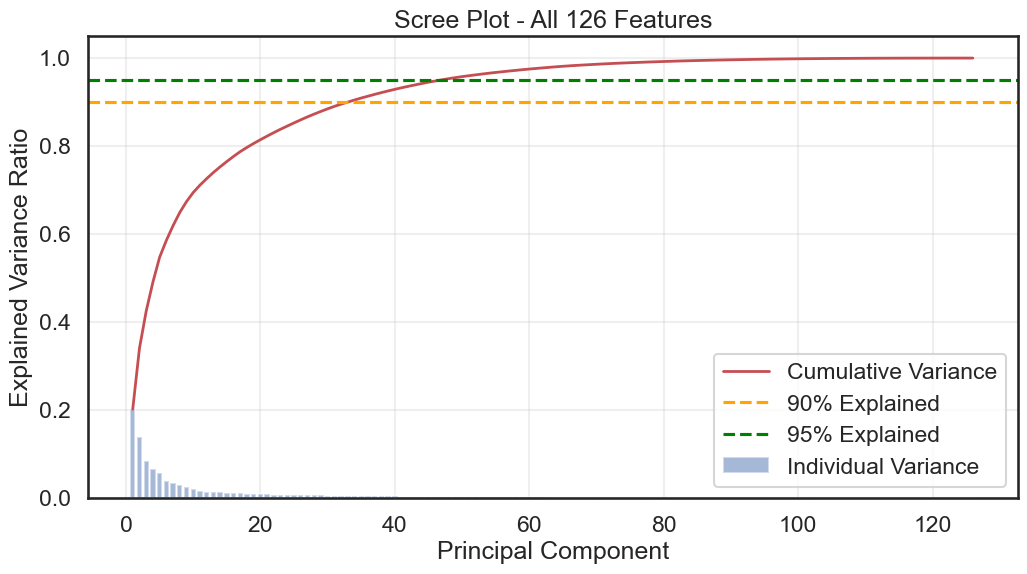

In [42]:
from sklearn.impute import SimpleImputer

# 1. Select all feature columns (exclude target)
all_features = numeric_df.drop(columns=['ViolentCrimesPerPop']).columns.tolist()
print(f"Analyzing {len(all_features)} features...")

# 2. Handle missing values (Impute with mean instead of dropping rows)
#    Dropping rows on 120+ cols might leave you with 0 data points!
imputer = SimpleImputer(strategy='mean')
X_all = imputer.fit_transform(numeric_df[all_features])
y_all = numeric_df['ViolentCrimesPerPop'].fillna(numeric_df['ViolentCrimesPerPop'].mean()).values

# 3. Standardize
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

# 4. Run PCA
U_all, s_all, Vt_all = np.linalg.svd(X_all_scaled, full_matrices=False)
eigenvalues_all = s_all**2 / (X_all.shape[0] - 1)
explained_var_all = eigenvalues_all / np.sum(eigenvalues_all)
cum_var_all = np.cumsum(explained_var_all)

# 5. Plot Scree Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(explained_var_all) + 1), cum_var_all, 'r-', linewidth=2, label='Cumulative Variance')
ax.bar(range(1, len(explained_var_all) + 1), explained_var_all, alpha=0.5, label='Individual Variance')

# Add thresholds
ax.axhline(y=0.90, color='orange', linestyle='--', label='90% Explained')
ax.axhline(y=0.95, color='green', linestyle='--', label='95% Explained')

ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title(f'Scree Plot - All {len(all_features)} Features')
ax.legend()
ax.grid(True, alpha=0.3)

# Find how many PCs needed for 90% variance
n_90 = np.argmax(cum_var_all >= 0.90) + 1
print(f"Number of PCs needed to explain 90% variance: {n_90}")
plt.show()


Top 15 Features by Loading Magnitude (Relevance to PC1 & PC2):
       Feature  PC1 Loading  PC2 Loading  Magnitude
     medIncome    -0.898152     0.305177   0.948583
     medFamInc    -0.905767     0.271716   0.945644
     RentHighQ    -0.719092     0.563421   0.913530
    RentMedian    -0.724539     0.554765   0.912535
       MedRent    -0.732926     0.519956   0.898629
      RentLowQ    -0.703326     0.553345   0.894907
 PctRecImmig10     0.108261     0.874656   0.881331
   PctKids2Par    -0.879651    -0.034420   0.880324
  PctRecImmig8     0.096977     0.874208   0.879571
OwnOccLowQuart    -0.662571     0.567870   0.872626
  PctRecImmig5     0.108737     0.864017   0.870833
    pctWInvInc    -0.869418    -0.047814   0.870732
  OwnOccMedVal    -0.648101     0.577196   0.867866
     perCapInc    -0.835422     0.228551   0.866121
PctPopUnderPov     0.866063     0.006008   0.866084


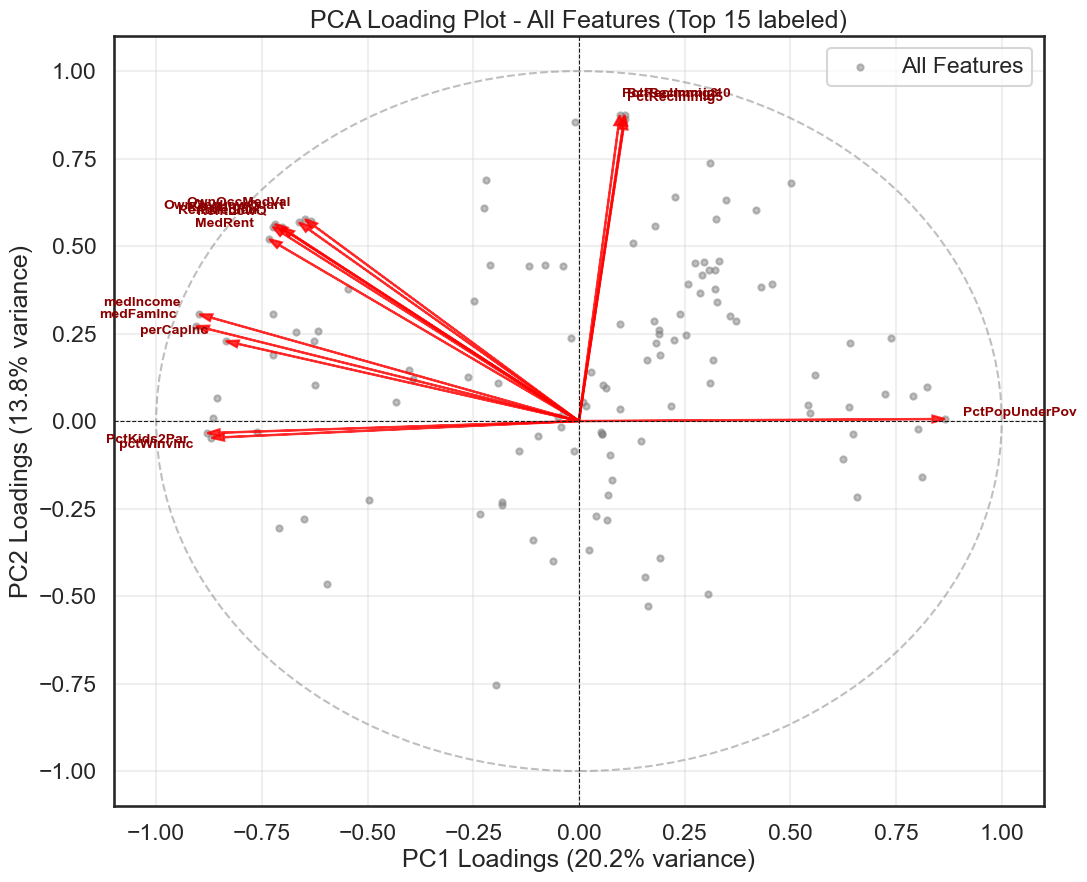

In [44]:
# Loading Plot for All Features
# Calculate loadings (correlation between original variables and PCs)
n_samples_all = X_all.shape[0]
loadings_all = Vt_all.T * (s_all / np.sqrt(n_samples_all - 1))
loadings_all_pc1 = loadings_all[:, 0]
loadings_all_pc2 = loadings_all[:, 1]

# Calculate magnitude of loadings to identify top features
loading_magnitudes = np.sqrt(loadings_all_pc1**2 + loadings_all_pc2**2)
top_n = 15  # Number of top features to label
top_indices = np.argsort(loading_magnitudes)[-top_n:]

# Create a DataFrame for the top features to display their values
top_features_data = []
for i in top_indices:
    top_features_data.append({
        'Feature': all_features[i],
        'PC1 Loading': loadings_all_pc1[i],
        'PC2 Loading': loadings_all_pc2[i],
        'Magnitude': loading_magnitudes[i]
    })

top_features_df = pd.DataFrame(top_features_data).sort_values('Magnitude', ascending=False)
print(f"\nTop {top_n} Features by Loading Magnitude (Relevance to PC1 & PC2):")
print(top_features_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 10))

# Plot all features as small points
ax.scatter(loadings_all_pc1, loadings_all_pc2, alpha=0.5, c='gray', s=20, label='All Features')

# Highlight top features
for i in top_indices:
    feat_x = loadings_all_pc1[i]
    feat_y = loadings_all_pc2[i]
    feature_name = all_features[i]
    
    # Draw arrow for top features
    ax.arrow(0, 0, feat_x, feat_y, color='red', alpha=0.8, head_width=0.02, length_includes_head=True)
    
    # Add text label with some offset/alignment logic
    ha = 'left' if feat_x >= 0 else 'right'
    va = 'bottom' if feat_y >= 0 else 'top'
    ax.text(feat_x * 1.05, feat_y * 1.05, feature_name, ha=ha, va=va, color='darkred', fontsize=10, fontweight='bold')

# Draw unit circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
ax.add_artist(circle)

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel(f'PC1 Loadings ({explained_var_all[0]:.1%} variance)')
ax.set_ylabel(f'PC2 Loadings ({explained_var_all[1]:.1%} variance)')
ax.set_title(f'PCA Loading Plot - All Features (Top {top_n} labeled)')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='k', linestyle='--', linewidth=0.8)
ax.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax.legend()

plt.show()

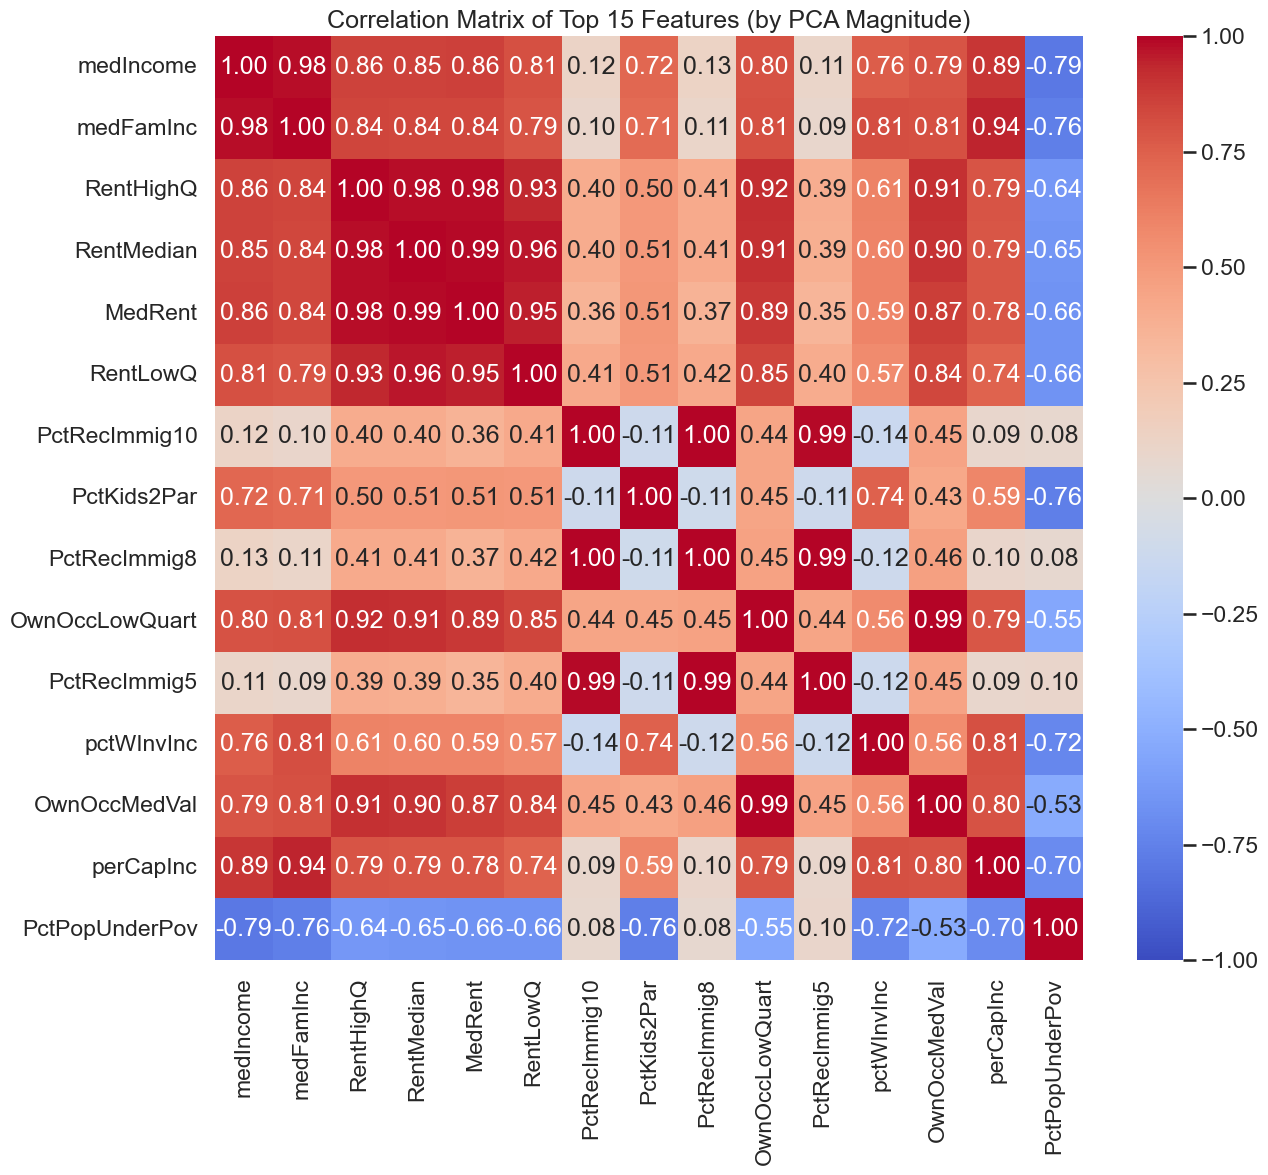

Highly Correlated Pairs (> 0.8):
------------------------------------------------------------
PctRecImmig10        <--> PctRecImmig8         : 0.996
OwnOccLowQuart       <--> OwnOccMedVal         : 0.994
PctRecImmig8         <--> PctRecImmig5         : 0.993
RentMedian           <--> MedRent              : 0.989
PctRecImmig10        <--> PctRecImmig5         : 0.986
RentHighQ            <--> RentMedian           : 0.982
medIncome            <--> medFamInc            : 0.978
RentHighQ            <--> MedRent              : 0.977
RentMedian           <--> RentLowQ             : 0.964
MedRent              <--> RentLowQ             : 0.950
medFamInc            <--> perCapInc            : 0.938
RentHighQ            <--> RentLowQ             : 0.931
RentHighQ            <--> OwnOccLowQuart       : 0.921
RentHighQ            <--> OwnOccMedVal         : 0.911
RentMedian           <--> OwnOccLowQuart       : 0.911
RentMedian           <--> OwnOccMedVal         : 0.898
medIncome            <--> 

In [45]:
# Check for Multicollinearity among the Top 15 Features

# 1. Get the data for these features
# We use the imputed data (X_all) to ensure we have no missing values
top_features_list = top_features_df['Feature'].values
indices = [all_features.index(f) for f in top_features_list]
X_top = X_all[:, indices]

df_top = pd.DataFrame(X_top, columns=top_features_list)

# 2. Calculate Correlation
corr_matrix_top = df_top.corr()

# 3. Plot Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_top, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Top 15 Features (by PCA Magnitude)')
plt.show()

# 4. List pairs with high correlation (> 0.8)
print("Highly Correlated Pairs (> 0.8):")
print("-" * 60)
high_corr = []
cols = corr_matrix_top.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr_matrix_top.iloc[i, j]
        if abs(val) > 0.8:
            high_corr.append((cols[i], cols[j], val))

# Sort by correlation strength
high_corr.sort(key=lambda x: abs(x[2]), reverse=True)

for f1, f2, val in high_corr:
    print(f"{f1:20} <--> {f2:20} : {val:.3f}")

['medIncome', 'MedRent', 'PctRecImmig10', 'PctKids2Par'] top picks